# Causal Inference Modeling of COMPAS data

### Criterion for Bias
- 1) TP and TN Rate by Race
- 2) Intervention by Race
- 3) Counterfactual Fairness by Race
- 4) Natural Direct Effects Identification of Race to Recitivism
- 5) Natural Indirect Effects Identification of Race to Recitivism

### 3 SCMs of Race towards Recitivism Predictions
- 1) Indirect (Almost all expected, with some understandable results)
    - 1) TP and TN Rate by Race (Expected: 1 - 3% difference between race is understndable, but non zero value is expected)
    - 2) Intervention by Race (Expected: Small effect of around 5% is understandable, but not zero is expected)
    - 3) Counterfactual Fairness by Race (Expected: Large of 43%)
    - 4) Natural Direct Effects Identification of Race to Recitivism (Expected: No effect detected)
    - 5) Natural Indirect Effects Identification of Race to Recitivism (Expected: -24% of White -> Will not Recommit)
- 2) Direct (Expected)
    - 1) TP and TN Rate by Race (Expected: Large bias)
    - 2) Intervention by Race (Expected: Large around 10-15%)
    - 3) Counterfactual Fairness by Race (Expected: Large around 50%)
    - 4) Natural Direct Effects Identification of Race to Recitivism (Expected: Large value of -23%)
    - 5) Natural Indirect Effects Identification of Race to Recitivism (Expected: Large value of -24%)
- 3) Unaware (Expected, when natural indirect effect identification can likely be attributed to unobserved confoudner)
    - 1) TP and TN Rate by Race (Expected: Low gap of 4-5% is expected due to in line with indirect, and expected from being non-zero)
    - 2) Intervention by Race (Expected: No impact)
    - 3) Counterfactual Fairness by Race (Expected, large impact of 50%)
    - 4) Natural Direct Effects Identification of Race to Recitivism (Expected, no impact detected)
    - 5) Natural Indirect Effects Identification of Race to Recitivism (Largely Expected: Large impact of -24% was detected. Likely due to unobserved confounder of race.)

In [98]:
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import pandas as pd
import tqdm
from sklearn.metrics import confusion_matrix,roc_auc_score,accuracy_score
from statistics import mean

%matplotlib inline

pyro.set_rng_seed(42)

# Data Import

In [99]:
data_file_path = 'data/compas-scores-two-years-short.csv'

# Model 1 - Indirect Race Path

### Read Model Parameters

In [226]:
# race
df = pd.read_csv('data/model1_race.csv')
race_alias = list(df['Var1'])
race_prob = torch.tensor(list(df['Freq']))

# sex
df = pd.read_csv('data/model1_sex.csv')
sex_alias = list(df['Var1'])
sex_prob = torch.tensor(list(df['Freq']) )

# age_cat
df = pd.read_csv('data/model1_age_cat.csv')
age_cat_alias = list(df['Var1'])
age_cat_prob = torch.tensor(list(df['Freq']) )



# priors_count
df = pd.read_csv('data/model1_priors_count.csv')
priors_count_alias = list(set( df['priors_count'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['sex'],row['age_cat'],row['priors_count'])] = row['Freq']
l0 = []
for r in race_alias:
    l1 = []
    for s in sex_alias:
        l2 = []
        for a in age_cat_alias:
            l3 = []
            for c in priors_count_alias:            
                l3 += [ dic[r,s,a,c] ]
            l2 +=  [ l3 ]
        l1 += [ l2 ]
    l0 += [ l1 ]

priors_count_probs = torch.tensor( l0 )

# two_year_recid
df = pd.read_csv('data/model1_two_year_recid.csv')
two_year_recid_alias = list(df['Unnamed: 0'])

l = []
for e in priors_count_alias:
    l += [ list( df[e] )  ]
two_year_recid_probs = torch.tensor( l )

### Define Model

In [227]:
def model():
    race = pyro.sample("race", dist.Categorical( race_prob )) 
    sex = pyro.sample("sex", dist.Categorical( sex_prob )) 
    age_cat = pyro.sample("age_cat", dist.Categorical( age_cat_prob )) 
    priors_count = pyro.sample("priors_count", dist.Categorical(priors_count_probs[race][sex][age_cat]))
    two_year_recid_prob = dist.Categorical(two_year_recid_probs[priors_count])
    two_year_recid = pyro.sample("two_year_recid", two_year_recid_prob)
    return two_year_recid

### TP vs FN Rate

In [ ]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {​"sex": torch.tensor(1), "two_year_recid": torch.tensor(0)}​)
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
combos = [(0, 0), (1, 0), (0, 1), (1, 1)]
for run in tqdm.tqdm(range(100)):
    z = 0
    for combo in combos:
        cur_ls = []
        for _ in range(num_sample):
            trace = posterior()
            r = trace.nodes['race']['value']
            a = trace.nodes['age_cat']['value']
            c = trace.nodes['priors_count']['value']
            do_model = pyro.do(model, data = {​"race": torch.tensor(combo[0]), 'sex': torch.tensor(combo[1])}​)
            counterfactual_model = pyro.condition(do_model, data = {​'race': r,'age_cat': a, 'priors_count': c }​)
            trace_counterfactual = pyro.poutine.trace(counterfactual_model)
            trace = trace_counterfactual.get_trace()
            z += trace.nodes['two_year_recid']['value']
        cur_ls += [ float(z)/num_sample ]
    ls.append(cur_ls)

In [31]:
df = pd.read_csv(data_file_path)

truth = []
preds = []
num_sample = 10
for index, row in df.iterrows():
    r = race_alias.index( row['race'] ) 
    s = sex_alias.index( row['sex'] ) 
    a = age_cat_alias.index( row['age_cat'] ) 
    c = priors_count_alias.index( row['priors_count'] ) 
    t = two_year_recid_alias.index( row['two_year_recid'] ) 
    conditioned_model = pyro.condition(model, data = {"race": torch.tensor( r ),
                                                      "sex": torch.tensor( s ),
                                                      "age_cat": torch.tensor( a ),
                                                      "priors_count": torch.tensor( c )
                                                     })
    posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
    trace = posterior()
    pred = int(trace.nodes['two_year_recid']['value'])
    truth += [ conditioned_model() ]
    preds += [ pred ]
    if ((index%500)==0):print(index//500)
truth = np.array(truth)
preds = np.array(preds)

# score for Black defendants
y_test_ = truth[ df['race']=='African-American' ]
y_pred_ = preds[ df['race']=='African-American' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (Black)      : ", fp/(fp+tn))
print("False negative rate (Black)      : ", fn/(fn+tp))
print("Accuracy (Black)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (Black)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_black = fp/(fp+tn)
fnr_black =  fn/(fn+tp)

# score for White defendants
y_test_ = truth[ df['race']=='Caucasian' ]
y_pred_ = preds[ df['race']=='Caucasian' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("\nFalse positive rate (White)      : ", fp/(fp+tn))
print("False negative rate (White)      : ", fn/(fn+tp))
print("Accuracy (White)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (White)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_white = fp/(fp+tn)
fnr_white =  fn/(fn+tp)

print('\nFalse positive rate Gap:', abs(fpr_black-fpr_white))
print('False negative rate Gap:', abs(fnr_black-fnr_white))

0
1
2
3
4
5
6
7
8
9
10
11
12
False positive rate (Black)      :  0.44549763033175355
False negative rate (Black)      :  0.5047301057317752
Accuracy (Black)      :   0.5257034632034632
AUC (Black)      :   0.5248861319682356

False positive rate (White)      :  0.4087912087912088
False negative rate (White)      :  0.5151515151515151
Accuracy (White)      :   0.5440097799511002
AUC (White)      :   0.5380286380286381

False positive rate Gap: 0.036706421540544765
False negative rate Gap: 0.010421409419739902


### Intervention
P(two_year_recid=1 | do(race=1)) - P(two_year_recid=1 | do(race=0))

In [32]:
ls = []
for run in tqdm.tqdm(range(100)):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'race': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]

100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


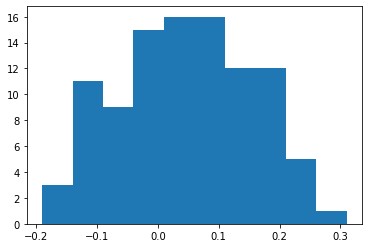

In [33]:
plt.hist(ls)
plt.show()

In [34]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.04920000000000003


### Counterfactual fairness

P(two_year_recid race=0 = 1 | race = 1, two_year_recid = 0)

In [194]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(0), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['priors_count']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(1)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:05<00:00, 17.43it/s]


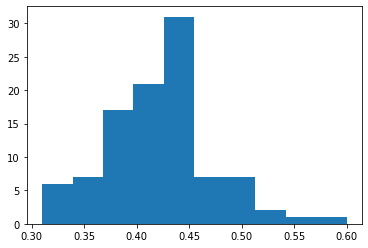

In [195]:
plt.hist(ls) 
plt.show()

In [196]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.4206000000000001


### Average Total Effect

In [197]:
'''Results in this one cell are to compute the total effects of E in case the
SCM to determine Y is incorrectly implementing an indicator function'''

num_samples = 1000
do_model = pyro.do(model, {'race': torch.tensor(1)})
samples = [do_model()['two_year_recid'] for _ in range(num_samples)]
p_y_1_DO_x_1 = sum(samples) / num_samples
p_y_1_DO_x_1

num_samples = 1000
do_model = pyro.do(model, {'race': torch.tensor(0)})
samples = [do_model()['two_year_recid'] for _ in range(num_samples)]
p_y_1_DO_x_0 = sum(samples) / num_samples
p_y_1_DO_x_0

TE = p_y_1_DO_x_1 - p_y_1_DO_x_0
print('Average Total Effects of E are', TE.numpy())

IndexError: too many indices for tensor of dimension 0

In [108]:
# E(Y|do(X=1))−E(Y|do(X=0)).
e1_samples = [pyro.do(model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(model, data={'race': torch.tensor(0)})() for _ in range(1000)]
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)
e1_avg - e2_avg

-0.07500000000000001

### Natural Effects

#### Natural Direct Effects

In [198]:
# When Z = 1 E(Y|(M = 1), do(X = 1)) - E(Y|(M = 1), do(X = 0))
cond_model = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [199]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [200]:
e1_avg

0.564

In [201]:
e2_avg

0.567

In [202]:
e1_avg - e2_avg

-0.0030000000000000027

#### Natural Indirect Effect

In [203]:
# When Z = 1 E(Y|(X = 1), do(M = 1)) - E(Y|(X = 1), do(M = 0))
cond_model = pyro.condition(model, data={'race': torch.tensor(1)})
e1_samples = [pyro.do(cond_model, data={'priors_count': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'priors_count': torch.tensor(0)})() for _ in range(1000)]

In [204]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [205]:
e1_avg - e2_avg

-0.26299999999999996

### Necessity and Sufficiency

#### Necessity

$P_{necessity} = P(Y_{X=1} = 0 | X=0, Y=1)$

In [228]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(0), "two_year_recid": torch.tensor(1)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_necessities = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(1)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_necessities.append(float(trace.nodes['two_year_recid']['value']))

In [229]:
p_necessity = 1 - mean(p_necessities)
print("P necessity =", p_necessity)

P necessity = 0.46099999999999997


#### Sufficiency

$P(Y_{X=0} = 1 | X=1, Y=0)$

In [230]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_sufficiencies = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(0)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_sufficiencies.append(float(trace.nodes['two_year_recid']['value']))

In [231]:
p_sufficiency = mean(p_sufficiencies)
print("P sufficiency =", p_sufficiency)

P sufficiency = 0.394


#### Necessity and Sufficiency

$PNS = P(X=0, Y=1) * PN + P(X=1, Y=0) * PS$

In [233]:
num_trials = 1000
num_x0_y1 = 0
num_x1_y0 = 0
trace_handler = pyro.poutine.trace(model)
for _ in range(num_trials):
    trace = trace_handler.get_trace()
    x = trace.nodes['race']['value']
    y = trace.nodes['two_year_recid']['value']
    if x == 0 and y == 1:
        num_x0_y1 += 1
    if x == 1 and y == 0:
        num_x1_y0 += 1

In [234]:
pns = (num_x0_y1 / num_trials) * p_necessity + (num_x1_y0 / num_trials) * p_sufficiency
print('PNS =', pns)

PNS = 0.217277


## Model 2 - Direct Race Path

### Read Model Parameters

In [235]:
# race
df = pd.read_csv('data/model2_race_race.csv')
race_alias = list(df['Var1'])
race_prob = torch.tensor(list(df['Freq']))

# sex
df = pd.read_csv('data/model2_race_sex.csv')
sex_alias = list(df['Var1'])
sex_prob = torch.tensor(list(df['Freq']) )

# age_cat
df = pd.read_csv('data/model2_race_age_cat.csv')
age_cat_alias = list(df['Var1'])
age_cat_prob = torch.tensor(list(df['Freq']) )

# priors_count
df = pd.read_csv('data/model2_race_priors_count.csv')
priors_count_alias = list(set( df['priors_count'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['sex'],row['age_cat'],row['priors_count'])] = row['Freq']
l0 = []
for r in race_alias:
    l1 = []
    for s in sex_alias:
        l2 = []
        for a in age_cat_alias:
            l3 = []
            for c in priors_count_alias:            
                l3 += [ dic[r,s,a,c] ]
            l2 +=  [ l3 ]
        l1 += [ l2 ]
    l0 += [ l1 ]

priors_count_probs = torch.tensor( l0 )

# two_year_recid
df = pd.read_csv('data/model2_race_two_year_recid.csv')
two_year_recid_alias = list(set( df['two_year_recid'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['priors_count'],row['two_year_recid'])] = row['Freq']
    
l0 = []
for r in race_alias:
    l1 = []
    for c in priors_count_alias:
        l2 = []
        for t in two_year_recid_alias:
            l2 += [ dic[r,c,t] ]
        l1 += [ l2 ]
    l0 += [ l1 ]

two_year_recid_probs = torch.tensor( l0 )

### Define model

In [236]:
def model():
    race = pyro.sample("race", dist.Categorical( race_prob )) 
    sex = pyro.sample("sex", dist.Categorical( sex_prob )) 
    age_cat = pyro.sample("age_cat", dist.Categorical( age_cat_prob )) 
    priors_count = pyro.sample("priors_count", dist.Categorical(priors_count_probs[race][sex][age_cat]))
    two_year_recid = pyro.sample("two_year_recid", dist.Categorical(two_year_recid_probs[race][priors_count]))
    return two_year_recid

In [52]:
df = pd.read_csv(data_file_path)

truth = []
preds = []
num_sample = 10
for index, row in df.iterrows():
    r = race_alias.index( row['race'] ) 
    s = sex_alias.index( row['sex'] ) 
    a = age_cat_alias.index( row['age_cat'] ) 
    c = priors_count_alias.index( row['priors_count'] ) 
    t = two_year_recid_alias.index( row['two_year_recid'] ) 
    conditioned_model = pyro.condition(model, data = {"race": torch.tensor( r ),
                                                      "sex": torch.tensor( s ),
                                                      "age_cat": torch.tensor( a ),
                                                      "priors_count": torch.tensor( c )
                                                     })
    posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
    trace = posterior()
    pred = int(trace.nodes['two_year_recid']['value'])
    truth += [ conditioned_model() ]
    preds += [ pred ]
    if ((index%500)==0):print(index//500)
truth = np.array(truth)
preds = np.array(preds)

# score for Black defendants
y_test_ = truth[ df['race']=='African-American' ]
y_pred_ = preds[ df['race']=='African-American' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (Black)      : ", fp/(fp+tn))
print("False negative rate (Black)      : ", fn/(fn+tp))
print("Accuracy (Black)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (Black)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_black = fp/(fp+tn)
fnr_black =  fn/(fn+tp)

# score for White defendants
y_test_ = truth[ df['race']=='Caucasian' ]
y_pred_ = preds[ df['race']=='Caucasian' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("\nFalse positive rate (White)      : ", fp/(fp+tn))
print("False negative rate (White)      : ", fn/(fn+tp))
print("Accuracy (White)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (White)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_white = fp/(fp+tn)
fnr_white =  fn/(fn+tp)

print('\nFalse positive rate Gap:', abs(fpr_black-fpr_white))
print('False negative rate Gap:', abs(fnr_black-fnr_white))

0
1
2
3
4
5
6
7
8
9
10
11
12
False positive rate (Black)      :  0.48879168944778567
False negative rate (Black)      :  0.4708087841456883
Accuracy (Black)      :   0.5202922077922078
AUC (Black)      :   0.520199763203263

False positive rate (White)      :  0.3785425101214575
False negative rate (White)      :  0.5617283950617284
Accuracy (White)      :   0.5488997555012225
AUC (White)      :   0.529864547408407

False positive rate Gap: 0.11024917932632816
False negative rate Gap: 0.09091961091604017


### Intervention

You are interested in the average causal effect P(two_year_recid = 1|do(race = 0)) − P(two_year_recid = 1|do(race = 1)),
where two_year_recid=1 represents recidivism, 
race=0 represents "African-American" 
race=1 represents "Caucasian" 

In [53]:
ls = []
for run in tqdm.tqdm(range(100)):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'race': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]

100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


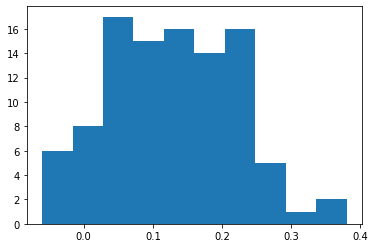

In [54]:
plt.hist(ls) 
plt.show()

In [55]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.1302


### Counterfactual fairness

In [56]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['priors_count']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:02<00:00, 35.54it/s]


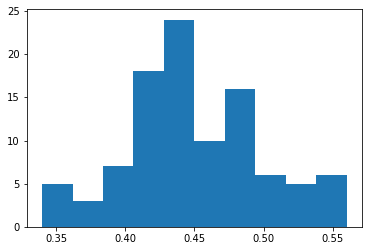

In [57]:
plt.hist(ls)
plt.show()

In [58]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.44969999999999993


### Average Total Effects

In [111]:
# E(Y|do(X=1))−E(Y|do(X=0)).
e1_samples = [pyro.do(model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(model, data={'race': torch.tensor(0)})() for _ in range(1000)]
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)
e1_avg - e2_avg

-0.10800000000000004

### Natural effects

#### Natural Direct Effects

In [59]:
# When Z = 1 E(Y|(M = 1), do(X = 1)) - E(Y|(M = 1), do(X = 0))
cond_model = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [60]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [61]:
e1_avg

0.273

In [62]:
e2_avg

0.357

In [63]:
e1_avg - e2_avg

-0.08399999999999996

#### Natural Indirect Effects

In [64]:
# NIE = E(Y | M=1, do(X=0)) – E(Y | M=0, do(X=0))
cond_model_1 = pyro.condition(model, data={'priors_count': torch.tensor(1)})
cond_model_2_race = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model_1, data={'race': torch.tensor(0)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model_2_race, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [65]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [66]:
e1_avg - e2_avg

0.21599999999999997

### Necessity and Sufficiency

#### Necessity

$P_{necessity} = P(Y_{X=1} = 0 | X=0, Y=1)$

In [237]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(0), "two_year_recid": torch.tensor(1)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_necessities = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(1)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_necessities.append(float(trace.nodes['two_year_recid']['value']))

In [238]:
p_necessity = 1 - mean(p_necessities)
print("P necessity =", p_necessity)

P necessity = 0.5449999999999999


#### Sufficiency

$P(Y_{X=0} = 1 | X=1, Y=0)$

In [239]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_sufficiencies = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(0)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_sufficiencies.append(float(trace.nodes['two_year_recid']['value']))

In [240]:
p_sufficiency = mean(p_sufficiencies)
print("P sufficiency =", p_sufficiency)

P sufficiency = 0.413


#### Necessity and Sufficiency

$PNS = P(X=0, Y=1) * PN + P(X=1, Y=0) * PS$

In [241]:
num_trials = 1000
num_x0_y1 = 0
num_x1_y0 = 0
trace_handler = pyro.poutine.trace(model)
for _ in range(num_trials):
    trace = trace_handler.get_trace()
    x = trace.nodes['race']['value']
    y = trace.nodes['two_year_recid']['value']
    if x == 0 and y == 1:
        num_x0_y1 += 1
    if x == 1 and y == 0:
        num_x1_y0 += 1

In [242]:
pns = (num_x0_y1 / num_trials) * p_necessity + (num_x1_y0 / num_trials) * p_sufficiency
print('PNS =', pns)

PNS = 0.264221


## Model 3

### Read data

In [245]:
# race
df = pd.read_csv('data/model3_race_race.csv')
race_alias = list(df['Var1'])
race_prob = torch.tensor(list(df['Freq']))

# sex
df = pd.read_csv('data/model3_race_sex.csv')
sex_alias = list(df['Var1'])
sex_prob = torch.tensor(list(df['Freq']) )

# age_cat
df = pd.read_csv('data/model3_race_age_cat.csv')
age_cat_alias = list(df['Var1'])
age_cat_prob = torch.tensor(list(df['Freq']) )

# priors_count
df = pd.read_csv('data/model3_race_priors_count.csv')
priors_count_alias = list(set( df['priors_count'] ))

dic = {}
for index, row in df.iterrows():
    dic[( row['sex'],row['age_cat'],row['priors_count'])] = row['Freq']
l1 = []
for s in sex_alias:
    l2 = []
    for a in age_cat_alias:
        l3 = []
        for c in priors_count_alias:            
            l3 += [ dic[s,a,c] ]
        l2 +=  [ l3 ]
    l1 += [ l2 ]

priors_count_probs = torch.tensor( l1 )

# two_year_recid
df = pd.read_csv('data/model3_race_two_year_recid.csv')
two_year_recid_alias = list(df['Unnamed: 0'])

l = []
for e in priors_count_alias:
    l += [ list( df[e] )  ]
two_year_recid_probs = torch.tensor( l )

### Define model

In [246]:
def model():
    race = pyro.sample("race", dist.Categorical( race_prob )) 
    sex = pyro.sample("sex", dist.Categorical( sex_prob )) 
    age_cat = pyro.sample("age_cat", dist.Categorical( age_cat_prob )) 
    priors_count = pyro.sample("priors_count", dist.Categorical(priors_count_probs[sex][age_cat]))
    two_year_recid = pyro.sample("two_year_recid", dist.Categorical(two_year_recid_probs[priors_count]))
    return two_year_recid


### Association

In [73]:
df = pd.read_csv(data_file_path)

truth = []
preds = []
num_sample = 10
for index, row in df.iterrows():
    r = race_alias.index( row['race'] ) 
    s = sex_alias.index( row['sex'] ) 
    a = age_cat_alias.index( row['age_cat'] ) 
    c = priors_count_alias.index( row['priors_count'] ) 
    t = two_year_recid_alias.index( row['two_year_recid'] ) 
    conditioned_model = pyro.condition(model, data = {"race": torch.tensor( r ),
                                                      "sex": torch.tensor( s ),
                                                      "age_cat": torch.tensor( a ),
                                                      "priors_count": torch.tensor( c )
                                                     })
    posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
    trace = posterior()
    pred = int(trace.nodes['two_year_recid']['value'])
    truth += [ conditioned_model() ]
    preds += [ pred ]
    if ((index%500)==0):print(index//500)
truth = np.array(truth)
preds = np.array(preds)

# score for Black defendants
y_test_ = truth[ df['race']=='African-American' ]
y_pred_ = preds[ df['race']=='African-American' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (Black)      : ", fp/(fp+tn))
print("False negative rate (Black)      : ", fn/(fn+tp))
print("Accuracy (Black)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (Black)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_black = fp/(fp+tn)
fnr_black =  fn/(fn+tp)

# score for White defendants
y_test_ = truth[ df['race']=='Caucasian' ]
y_pred_ = preds[ df['race']=='Caucasian' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("\nFalse positive rate (White)      : ", fp/(fp+tn))
print("False negative rate (White)      : ", fn/(fn+tp))
print("Accuracy (White)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (White)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_white = fp/(fp+tn)
fnr_white =  fn/(fn+tp)

print('\nFalse positive rate Gap:', abs(fpr_black-fpr_white))
print('False negative rate Gap:', abs(fnr_black-fnr_white))

0
1
2
3
4
5
6
7
8
9
10
11
12
False positive rate (Black)      :  0.4429175475687104
False negative rate (Black)      :  0.48725055432372505
Accuracy (Black)      :   0.5354437229437229
AUC (Black)      :   0.5349159490537823

False positive rate (White)      :  0.42446573323507736
False negative rate (White)      :  0.5241567912488605
Accuracy (White)      :   0.5309698451507743
AUC (White)      :   0.525688737758031

False positive rate Gap: 0.01845181433363302
False negative rate Gap: 0.03690623692513545


### Intervention

In [74]:
# You are interested in the average causal effect P(two_year_recid = 1|do(race = 0)) − P(two_year_recid = 1|do(race = 1)),
# where two_year_recid=1 represents recidivism, 
# race=0 represents "African-American" 
# race=0 represents "Caucasian" 

In [75]:
ls = []
for run in tqdm.tqdm(range(100)):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'race': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]

100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


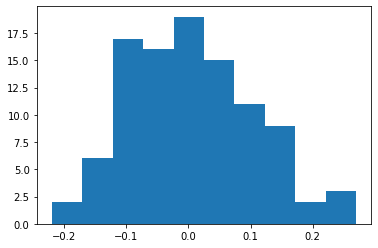

In [76]:
plt.hist(ls)
plt.show()

In [77]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.008299999999999995


### Counterfactual fairness

In [78]:
# P(two_year_recid race=0 = 1|race = 1,two_year_recid = 0)

In [79]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['priors_count']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:02<00:00, 36.73it/s]


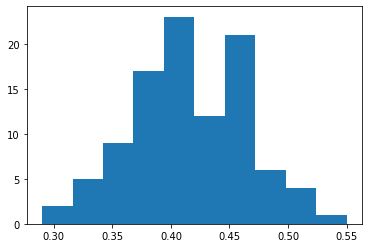

In [80]:
plt.hist(ls)
plt.show()

In [81]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.41679999999999995


In [82]:
# P(two_year_recid race=1 = 1|race = 0,two_year_recid = 1)

In [83]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(0), "two_year_recid": torch.tensor(1)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['priors_count']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(1)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:02<00:00, 36.48it/s]


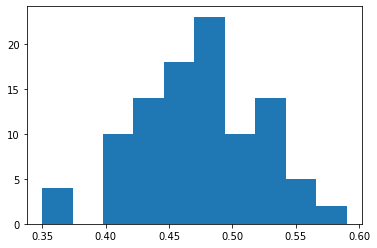

In [84]:
plt.hist(ls)
plt.show()

In [85]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.4728000000000001


### Average Total Effects

In [114]:
# E(Y|do(X=1))−E(Y|do(X=0)).
e1_samples = [pyro.do(model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(model, data={'race': torch.tensor(0)})() for _ in range(1000)]
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)
e1_avg - e2_avg

-0.004999999999999949

### Natural effects

#### Natural Direct Effects

In [86]:
# When Z = 1 E(Y|(M = 1), do(X = 1)) - E(Y|(M = 1), do(X = 0))
cond_model = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [87]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [88]:
e1_avg

0.32

In [89]:
e2_avg

0.33

In [90]:
e1_avg - e2_avg

-0.010000000000000009

#### Natural Indirect Effects

In [91]:
# NIE = E(Y | M=1, do(X=0)) – E(Y | M=0, do(X=0))
cond_model_1 = pyro.condition(model, data={'priors_count': torch.tensor(1)})
cond_model_2 = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model_1, data={'race': torch.tensor(0)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model_2, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [92]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [93]:
e1_avg - e2_avg

0.26899999999999996

### Necessity and Sufficiency

#### Necessity

$P_{necessity} = P(Y_{X=1} = 0 | X=0, Y=1)$

In [247]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(0), "two_year_recid": torch.tensor(1)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_necessities = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(1)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_necessities.append(float(trace.nodes['two_year_recid']['value']))

In [248]:
p_necessity = 1 - mean(p_necessities)
print("P necessity =", p_necessity)

P necessity = 0.486


#### Sufficiency

$P(Y_{X=0} = 1 | X=1, Y=0)$

In [249]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_sufficiencies = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(0)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_sufficiencies.append(float(trace.nodes['two_year_recid']['value']))

In [250]:
p_sufficiency = mean(p_sufficiencies)
print("P sufficiency =", p_sufficiency)

P sufficiency = 0.429


#### Necessity and Sufficiency

$PNS = P(X=0, Y=1) * PN + P(X=1, Y=0) * PS$

In [251]:
num_trials = 1000
num_x0_y1 = 0
num_x1_y0 = 0
trace_handler = pyro.poutine.trace(model)
for _ in range(num_trials):
    trace = trace_handler.get_trace()
    x = trace.nodes['race']['value']
    y = trace.nodes['two_year_recid']['value']
    if x == 0 and y == 1:
        num_x0_y1 += 1
    if x == 1 and y == 0:
        num_x1_y0 += 1

In [252]:
pns = (num_x0_y1 / num_trials) * p_necessity + (num_x1_y0 / num_trials) * p_sufficiency
print('PNS =', pns)

PNS = 0.213675
